In [1]:
from paths import DATA_DIR, CKPT_FOLDER

import matplotlib.pyplot as plt
import numpy as np
import torch
import scanpy as sc
import scvelo as scv

import anndata
import pandas as pd

from torchdyn.core import NeuralODE

from scCFM.datamodules.time_sc_datamodule import TrajectoryDataModule
from scCFM.models.cfm.components.mlp import MLP
from scCFM.models.cfm.cfm_module import CFMLitModule

from notebooks.utils import (real_reconstructed_cells_adata,
                             add_velocity_to_adata, 
                             compute_velocity_projection, 
                             compute_trajectory, 
                             decode_trajectory)
import scib
from scib_metrics.benchmark import Benchmarker, BatchCorrection

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

**Utils**

In [107]:
def standardize_adata(adata, key):
    """
    standardize anndata and add a key to adata.layers
    """
    X_copy = adata.X.copy()
    adata.layers[key] = (X_copy - np.mean(X_copy, axis=0)) / np.std(X_copy, axis=0)
    
def add_keys_to_dict(metric_dict, metric_list):
    metric_list_zipped = dict(zip(metric_list[0], metric_list[1]))
    for m in metric_list_zipped:
        if m in metric_dict:
            metric_dict[m].append(metric_list_zipped[m])
        else:
            metric_dict[m] = []
            metric_dict[m].append(metric_list_zipped[m])
    return metric_dict

**Read the anndata files**

In [3]:
adata_latent_vae = sc.read_h5ad(DATA_DIR / "eb" / "flat" / "eb_lib.h5ad")
adata_latent_flat = sc.read_h5ad(DATA_DIR / "eb" / "flat" / "eb_flat_lib.h5ad")

/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


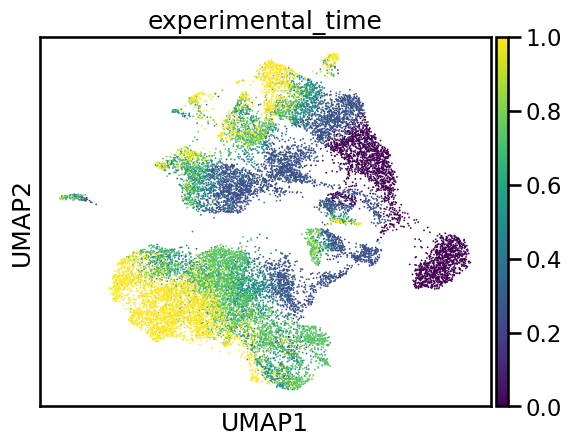

In [4]:
sc.pl.umap(adata_latent_vae, color="experimental_time")

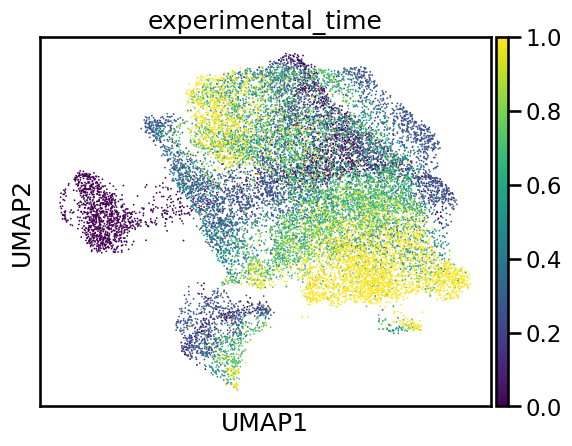

In [5]:
sc.pl.umap(adata_latent_flat, color="experimental_time")

Initialize datamodule

In [6]:
datamodule_kwargs_vae = {'path': '/nfs/homedirs/pala/scCFM/project_dir/data/eb/flat/eb_lib.h5ad',
                          'x_layer': 'X_latents',
                          'time_key': 'experimental_time', 
                          'use_pca': False, 
                          'n_dimensions': None, 
                          'train_val_test_split': [0.9, 0.1], 
                          'num_workers': 2, 
                          'batch_size': 512, 
                          'model_library_size': True}

datamodule_kwargs_flat = {'path': '/nfs/homedirs/pala/scCFM/project_dir/data/eb/flat/eb_flat_lib.h5ad',
                          'x_layer': 'X_latents',
                          'time_key': 'experimental_time', 
                          'use_pca': False, 
                          'n_dimensions': None, 
                          'train_val_test_split': [0.9, 0.1], 
                          'num_workers': 2, 
                          'batch_size': 512, 
                           'model_library_size': True}

# Initialize the datamodules 
datamodule_vae = TrajectoryDataModule(**datamodule_kwargs_vae)
datamodule_flat = TrajectoryDataModule(**datamodule_kwargs_flat)

# Mapping real times to index
idx2time = datamodule_vae.idx2time

Velocity field network

In [7]:
net_hparams = {"dim": datamodule_vae.dim,
                "w": 64,
                "time_varying": True}

net_vae = MLP(**net_hparams).to(device)
net_flat = MLP(**net_hparams).to(device)

CFM model 

In [8]:
cfm_kwargs = {'ot_sampler': 'exact', 
                   'sigma': 0.1, 
                   'use_real_time': False, 
                   'lr': 0.001, 
                   'antithetic_time_sampling': True}

cfm_vae = CFMLitModule(net=net_vae, datamodule=datamodule_vae, **cfm_kwargs).to(device)
cfm_flat = CFMLitModule(net=net_flat, datamodule=datamodule_flat, **cfm_kwargs).to(device)

In [9]:
cfm_vae.load_state_dict(torch.load(CKPT_FOLDER / "trajectory" / "eb" / "best_cfm_model_eb.ckpt")["state_dict"])
cfm_flat.load_state_dict(torch.load(CKPT_FOLDER / "trajectory" / "eb" / "best_cfm_model_flat_eb.ckpt")["state_dict"])

<All keys matched successfully>

**Plot the velocities**

In [10]:
add_velocity_to_adata(adata_latent_vae, cfm_vae, device)
add_velocity_to_adata(adata_latent_flat, cfm_flat, device)

Non geometric

  0%|          | 0/18176 [00:00<?, ?cell/s]

  0%|          | 0/18176 [00:00<?, ?cell/s]

/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


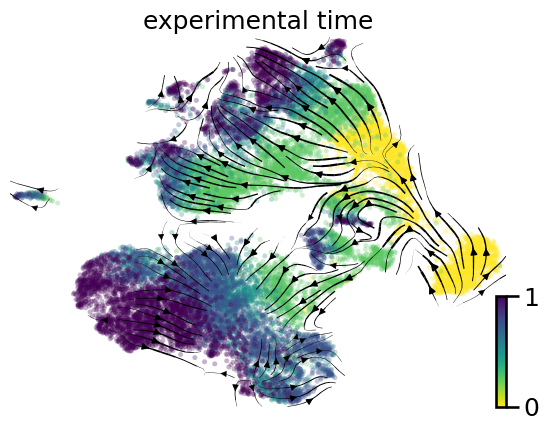

In [11]:
compute_velocity_projection(adata_latent_vae, "X_latents", "velocity", "umap")
scv.pl.velocity_embedding_stream(adata_latent_vae, vkey="T_fwd", basis="umap", color="experimental_time")

  0%|          | 0/18176 [00:00<?, ?cell/s]

  0%|          | 0/18176 [00:00<?, ?cell/s]

/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


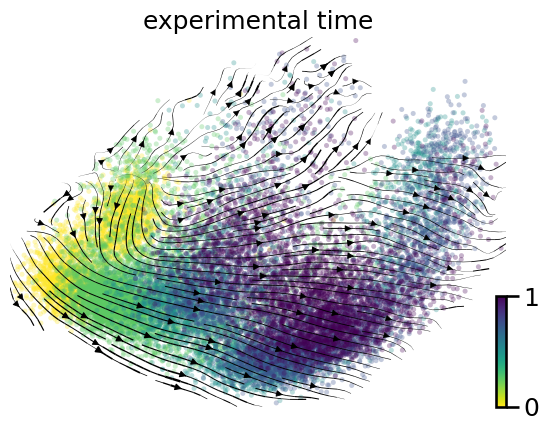

In [12]:
compute_velocity_projection(adata_latent_vae, "X_latents", "velocity", "pca")
scv.pl.velocity_embedding_stream(adata_latent_vae, vkey="T_fwd", basis="pca", color="experimental_time")

Geometric

  0%|          | 0/18176 [00:00<?, ?cell/s]

  0%|          | 0/18176 [00:00<?, ?cell/s]

/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


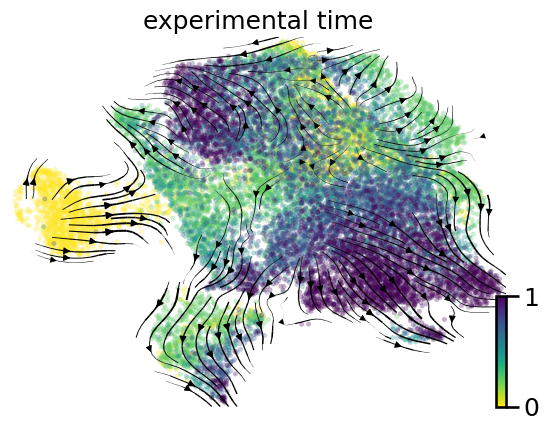

In [13]:
compute_velocity_projection(adata_latent_flat, "X_latents", "velocity", "umap")
scv.pl.velocity_embedding_stream(adata_latent_flat, vkey="T_fwd", basis="umap", color="experimental_time")

  0%|          | 0/18176 [00:00<?, ?cell/s]

  0%|          | 0/18176 [00:00<?, ?cell/s]

/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


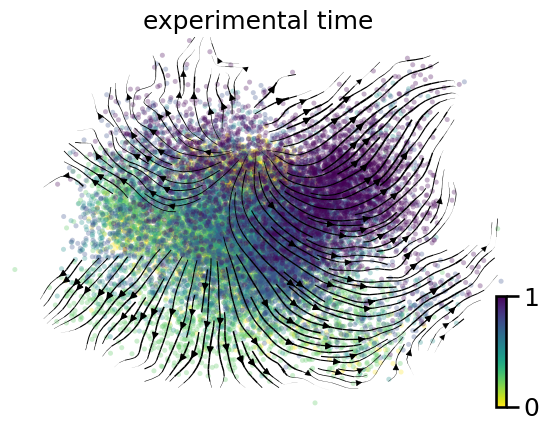

In [14]:
compute_velocity_projection(adata_latent_flat, "X_latents", "velocity", "pca")
scv.pl.velocity_embedding_stream(adata_latent_flat, vkey="T_fwd", basis="pca", color="experimental_time")

**Evaluate push forward from time 0**

In [15]:
X_adata_t0_vae = torch.from_numpy(adata_latent_vae[adata_latent_vae.obs["experimental_time"]==0].X).to(device)
X_adata_t0_flat = torch.from_numpy(adata_latent_flat[adata_latent_flat.obs["experimental_time"]==0].X).to(device)

l_t0_vae = adata_latent_vae.obs.loc[adata_latent_vae.obs["experimental_time"]==0, "log_library_size"].to_numpy()
l_t0_flat = adata_latent_flat.obs.loc[adata_latent_flat.obs["experimental_time"]==0, "log_library_size"].to_numpy()

l_t0_vae = torch.from_numpy(l_t0_vae).to(device)
l_t0_flat = torch.from_numpy(l_t0_flat).to(device)

In [16]:
traj_vae, times_vae = compute_trajectory(X_adata_t0_vae, 
                                         l_t0_vae,
                                         cfm_vae, 
                                         idx2time, 
                                         device, 
                                         use_real_time=False)

traj_flat, times_flat = compute_trajectory(X_adata_t0_flat, 
                                           l_t0_flat,
                                           cfm_flat, 
                                           idx2time, 
                                           device, 
                                           use_real_time=False)

times_vae = pd.DataFrame(times_vae)
times_flat = pd.DataFrame(times_flat)

times_vae.columns = ["experimental_time"]
times_flat.columns = ["experimental_time"]

Create trajectory anndata

/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


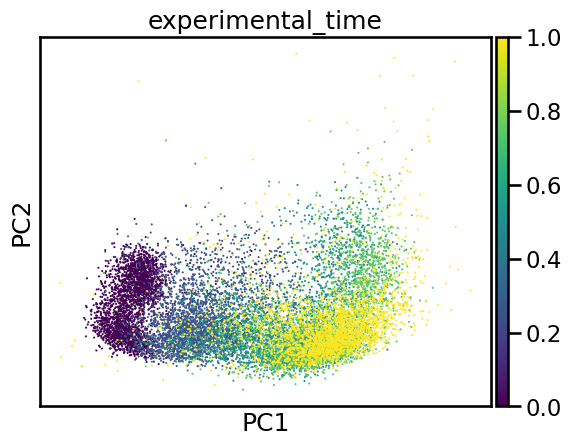

/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


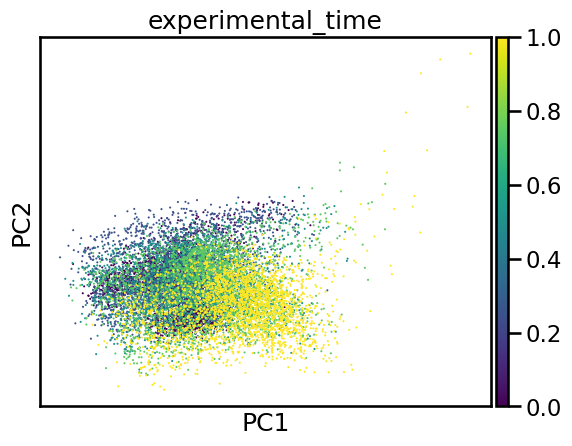

In [17]:
adata_simulated_vae = anndata.AnnData(X=traj_vae.detach().numpy(), 
                                     obs=times_vae)
sc.tl.pca(adata_simulated_vae)
sc.pl.pca(adata_simulated_vae, color="experimental_time")

adata_simulated_flat = anndata.AnnData(X=traj_flat.detach().numpy(),
                                      obs=times_flat)
sc.tl.pca(adata_simulated_flat)
sc.pl.pca(adata_simulated_flat, color="experimental_time")

In [18]:
sc.pp.neighbors(adata_simulated_vae, 30)
sc.tl.umap(adata_simulated_vae)

sc.pp.neighbors(adata_simulated_flat, 30)
sc.tl.umap(adata_simulated_flat)

/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/umap/distances.py:108

/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


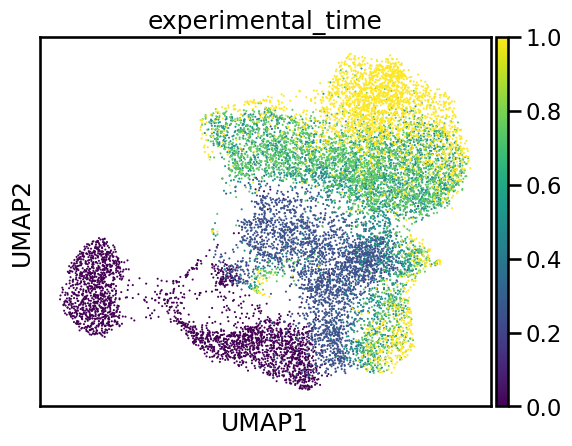

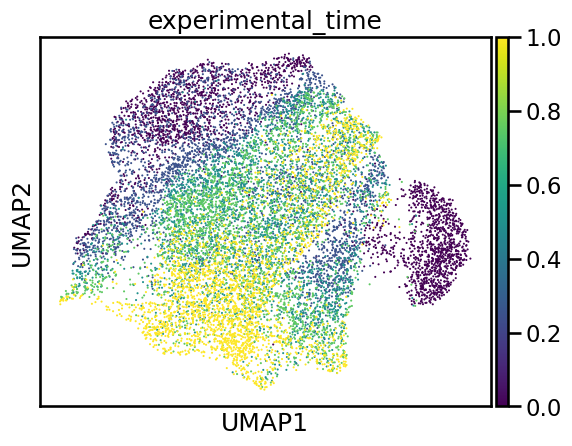

In [19]:
sc.pl.umap(adata_simulated_vae, color = "experimental_time")
sc.pl.umap(adata_simulated_flat, color = "experimental_time")

In [20]:
concat_flat = anndata.concat([adata_simulated_flat, adata_latent_flat])
dataset_type = ["simulated" for i in range(len(adata_simulated_flat))] + ["real" for i in range(len(adata_latent_flat))]
concat_flat.obs["dataset_type"] = dataset_type

concat_vae = anndata.concat([adata_simulated_vae, adata_latent_vae])
dataset_type = ["simulated" for i in range(len(adata_simulated_vae))] + ["real" for i in range(len(adata_latent_vae))]
concat_vae.obs["dataset_type"] = dataset_type

/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


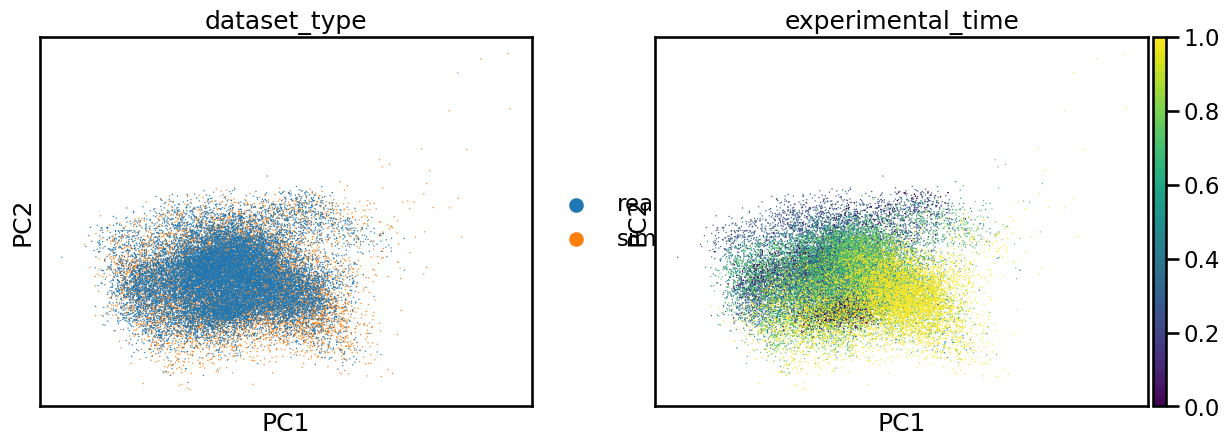

/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


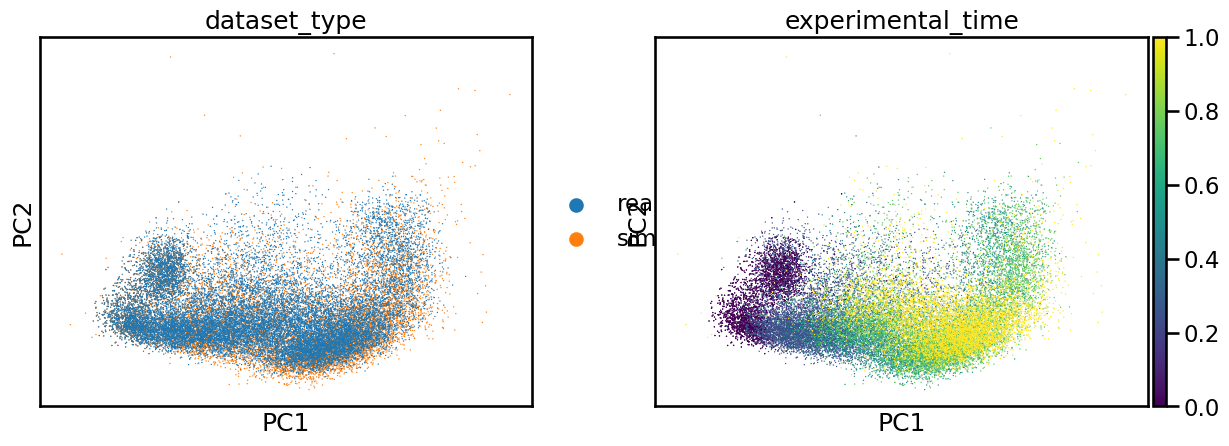

In [21]:
sc.pp.pca(concat_flat)
sc.pl.pca(concat_flat, color=["dataset_type","experimental_time"])

sc.pp.pca(concat_vae)
sc.pl.pca(concat_vae, color=["dataset_type","experimental_time"])

In [22]:
sc.pp.neighbors(concat_flat, 30)
sc.tl.umap(concat_flat)

sc.pp.neighbors(concat_vae, 30)
sc.tl.umap(concat_vae)

/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


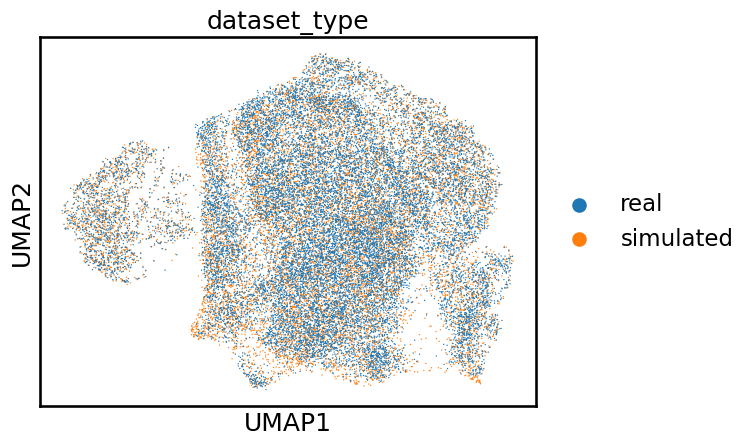

/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


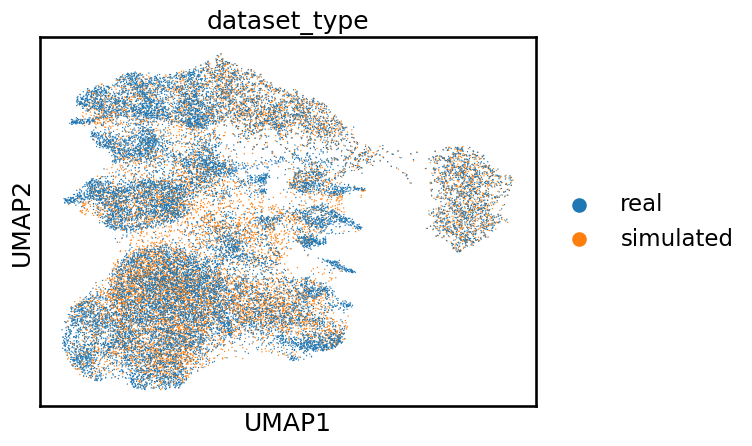

In [23]:
sc.pl.umap(concat_flat, color = ["dataset_type"])

sc.pl.umap(concat_vae, color = ["dataset_type"])

**Decoded trajectories**

In [24]:
from scCFM.models.base.vae import VAE
from scCFM.models.base.geometric_vae import GeometricNBVAE
from scCFM.datamodules.sc_datamodule import scDataModule

from paths import PROJECT_FOLDER

In [25]:
datamodule={'path': '/nfs/homedirs/pala/scCFM/project_dir/data/eb/processed/eb_phate.h5ad', 
            'x_layer': 'X_norm', 
            'cond_keys': ['experimental_time', 'leiden'],
            'use_pca': False, 
            'n_dimensions': None, 
            'train_val_test_split': [1], 
            'batch_size': 512, 
            'num_workers': 2}

# Initialize datamodule
datamodule = scDataModule(**datamodule)

Initialize geometric autoencoder 

In [26]:
model_vae={
       'in_dim': datamodule.in_dim,
       'n_epochs_anneal_kl': 1000, 
       'kl_weight': None, 
       'likelihood': 'nb', 
       'dropout': False, 
       'learning_rate': 0.001, 
       'dropout_p': False, 
       'model_library_size': True, 
       'batch_norm': True, 
       'library_size_regression': False, 
       'data_library_size': True, 
       'kl_warmup_fraction': 0.1, 
       'hidden_dims': [256, 10]}
        
geometric={'compute_metrics_every': 1, 
           'use_c': True, 
           'l2': True, 
           'eta_interp': 0, 
           'interpolate_z': False, 
           'start_jac_after': 0, 
           'fl_weight': 0.1,
           'detach_theta': True}

In [27]:
vae = GeometricNBVAE(**geometric, vae_kwargs=model_vae).to(cfm_vae.device)
geometric_vae = GeometricNBVAE(**geometric, vae_kwargs=model_vae).to(cfm_vae.device)

In [28]:
vae.load_state_dict(torch.load(PROJECT_FOLDER / "checkpoints/ae/eb/best_model_vae_lib.ckpt")["state_dict"])
geometric_vae.load_state_dict(torch.load(PROJECT_FOLDER / "checkpoints/ae/eb/best_model_geometric_lib.ckpt")["state_dict"])

vae.eval()
geometric_vae.eval()

GeometricNBVAE(
  (encoder_layers): MLP(
    (net): Sequential(
      (0): Sequential(
        (0): Linear(in_features=1241, out_features=256, bias=True)
        (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ELU(alpha=1.0)
      )
    )
  )
  (decoder_layers): MLP(
    (net): Sequential(
      (0): Sequential(
        (0): Linear(in_features=10, out_features=256, bias=True)
        (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ELU(alpha=1.0)
      )
    )
  )
  (library_size_decoder): Linear(in_features=10, out_features=1, bias=True)
  (decoder_mu_lib): Linear(in_features=256, out_features=1241, bias=True)
  (mu_logvar): Linear(in_features=256, out_features=20, bias=True)
)

Compute the trajectories 

In [29]:
mu_traj_vae, x_traj_vae, times_traj_vae = decode_trajectory(X_adata_t0_vae,
                                                            l_t0_vae,
                                                            cfm_vae,
                                                            vae,
                                                            idx2time, 
                                                            device, 
                                                            False)

mu_traj_flat, x_traj_flat, times_traj_flat = decode_trajectory(X_adata_t0_flat,
                                                               l_t0_flat,
                                                               cfm_flat,
                                                               geometric_vae,
                                                               idx2time, 
                                                               device, 
                                                               False)

Assemble the trajectories into anndata files

In [30]:
times_traj_vae = pd.DataFrame(times_traj_vae)
times_traj_flat = pd.DataFrame(times_traj_flat)

times_traj_vae.columns = ["experimental_time"]
times_traj_flat.columns = ["experimental_time"]

adata_x_traj_vae = anndata.AnnData(X=mu_traj_vae.detach().numpy(), 
                                     obs=times_traj_vae)
adata_x_traj_flat = anndata.AnnData(X=mu_traj_flat.detach().numpy(),
                                      obs=times_traj_flat)

/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


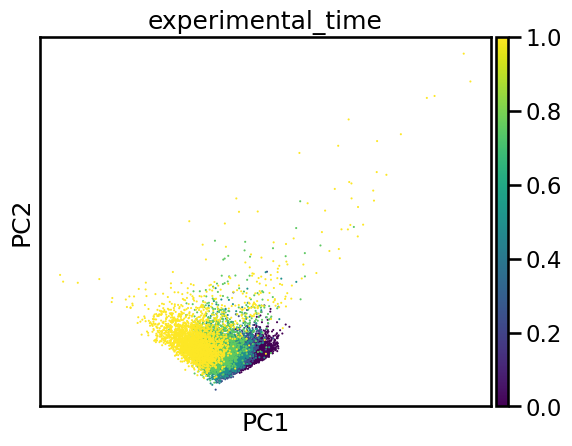

/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


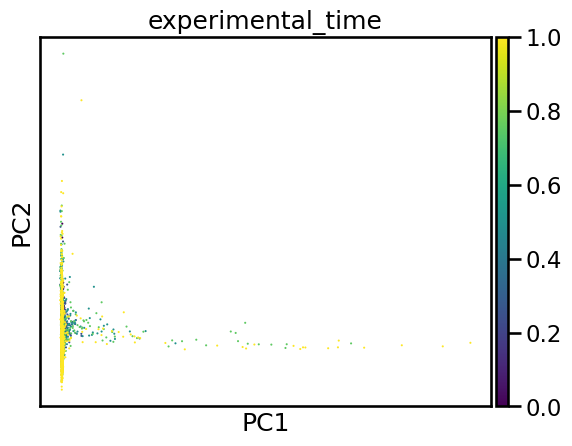

In [31]:
sc.pp.pca(adata_x_traj_vae)
sc.pl.pca(adata_x_traj_vae, color=["experimental_time"])

sc.pp.pca(adata_x_traj_flat)
sc.pl.pca(adata_x_traj_flat, color=["experimental_time"])

In [32]:
sc.pp.neighbors(adata_x_traj_vae, 30)
sc.tl.umap(adata_x_traj_vae)

sc.pp.neighbors(adata_x_traj_flat, 30)
sc.tl.umap(adata_x_traj_flat)

/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


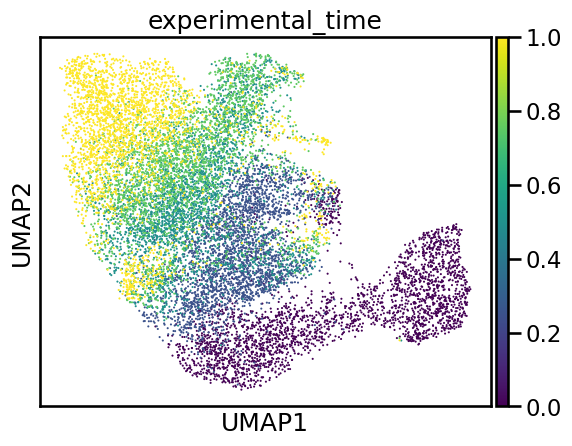

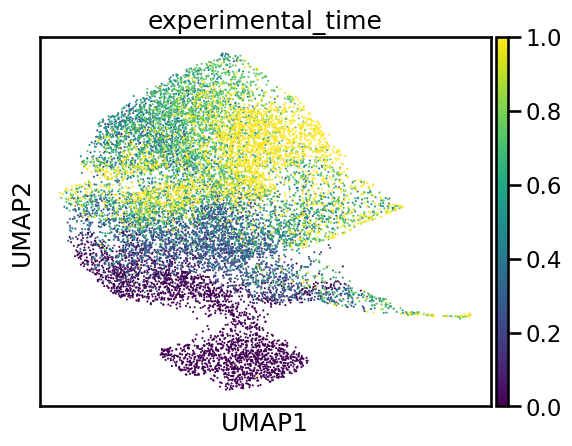

In [33]:
sc.pl.umap(adata_x_traj_vae, color = ["experimental_time"])

sc.pl.umap(adata_x_traj_flat, color = ["experimental_time"])

Read original data and collect the normalization layer

In [34]:
adata_eb_original = sc.read_h5ad('/nfs/homedirs/pala/scCFM/project_dir/data/eb/processed/eb_phate.h5ad')

adata_eb_original.X = adata_eb_original.layers["X_norm"].copy()

Read original data and collect the normalization layer

In [35]:
adata_x_traj_vae.var.index = adata_eb_original.var.index
adata_x_traj_flat.var.index = adata_eb_original.var.index

concat_vae_x = anndata.concat([adata_x_traj_vae, adata_eb_original])
dataset_type = ["simulated" for i in range(len(adata_x_traj_vae))] + ["real" for i in range(len(adata_eb_original))]
concat_vae_x.obs["dataset_type"] = dataset_type

concat_flat_x = anndata.concat([adata_x_traj_flat, adata_eb_original])
dataset_type = ["simulated" for i in range(len(adata_x_traj_flat))] + ["real" for i in range(len(adata_eb_original))]
concat_flat_x.obs["dataset_type"] = dataset_type

In [36]:
# sc.pp.log1p(concat_vae_x)
# sc.pp.log1p(concat_flat_x)

/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


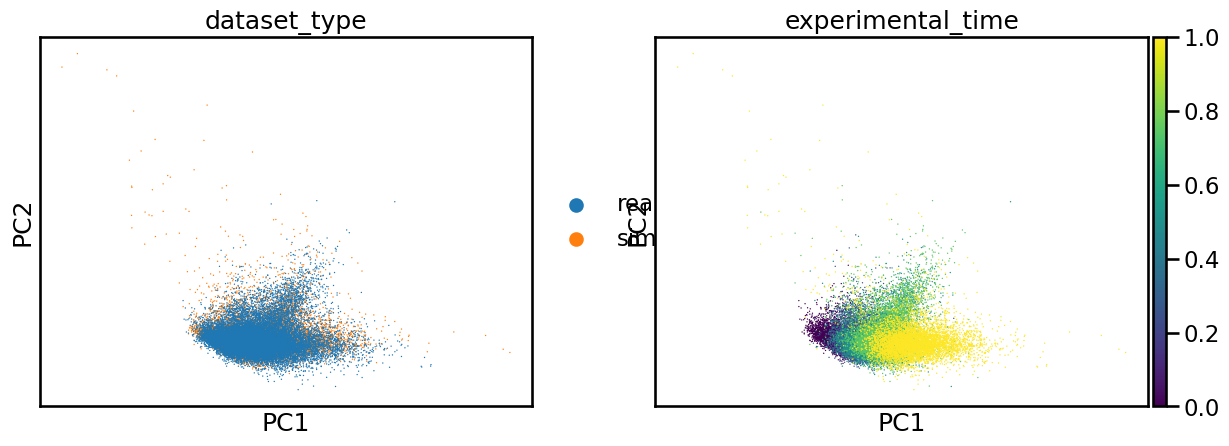

/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


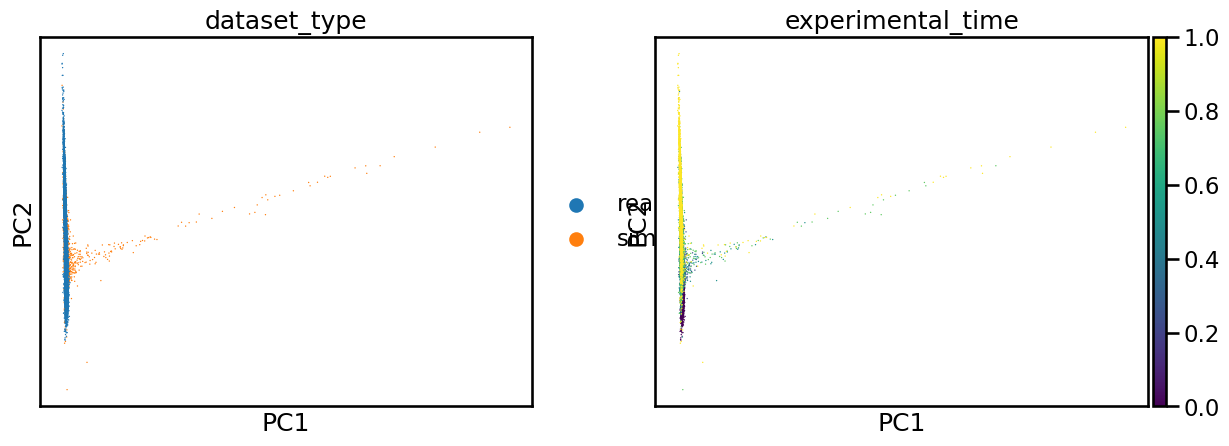

In [37]:
sc.pp.pca(concat_vae_x)
sc.pl.pca(concat_vae_x, color=["dataset_type","experimental_time"])

sc.pp.pca(concat_flat_x)
sc.pl.pca(concat_flat_x, color=["dataset_type","experimental_time"])

In [38]:
sc.pp.neighbors(concat_vae_x, 30)
sc.tl.umap(concat_vae_x)

sc.pp.neighbors(concat_flat_x, 30)
sc.tl.umap(concat_flat_x)

/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


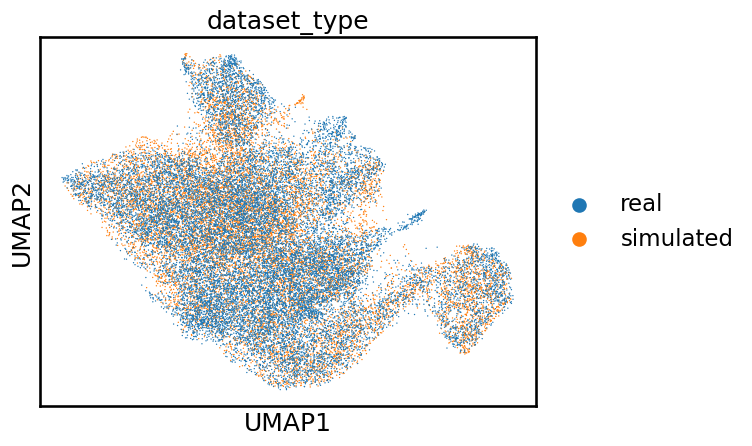

/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


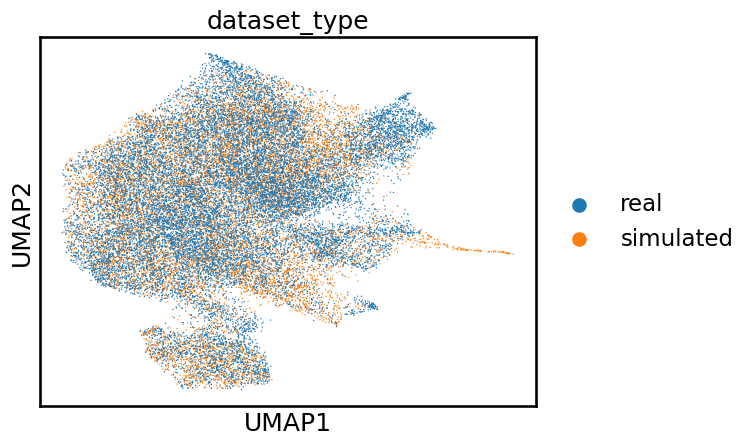

In [39]:
sc.pl.umap(concat_vae_x, color = ["dataset_type"])

sc.pl.umap(concat_flat_x, color = ["dataset_type"])

**Check scIB metrics latent space**

In [48]:
concat_vae.obsm["X_latents"] = concat_vae.X.copy()
concat_flat.obsm["X_latents"] = concat_flat.X.copy()

/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
Metrics:  10%|█         | 1/10 [00:13<02:00, 13.42s/it, Bio conservation: nmi_ari_cluster_labels_kmeans]/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass val

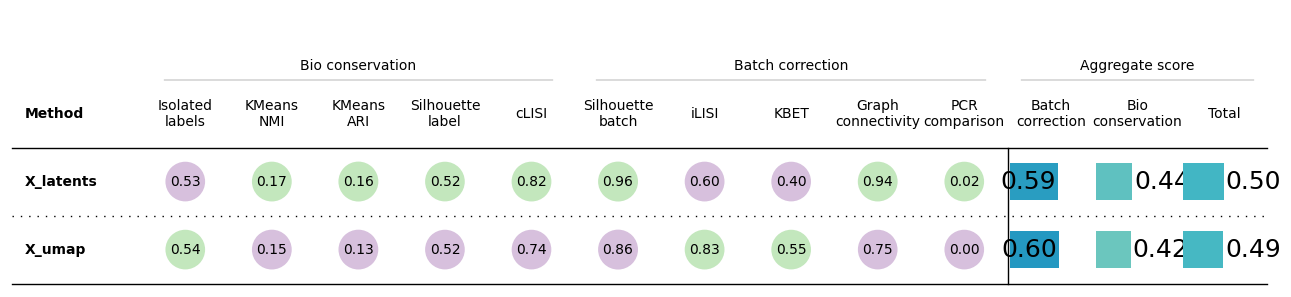

In [54]:
bm_latent_vae = Benchmarker(
    concat_vae[concat_vae.obs.experimental_time>0],
    batch_key="dataset_type",
    label_key="experimental_time",
    embedding_obsm_keys=["X_latents", "X_umap"],
    n_jobs=1,
)
bm_latent_vae.benchmark()
bm_latent_vae.plot_results_table(min_max_scale=False)

/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
Metrics:  10%|█         | 1/10 [00:14<02:09, 14.36s/it, Bio conservation: nmi_ari_cluster_labels_kmeans]/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass val

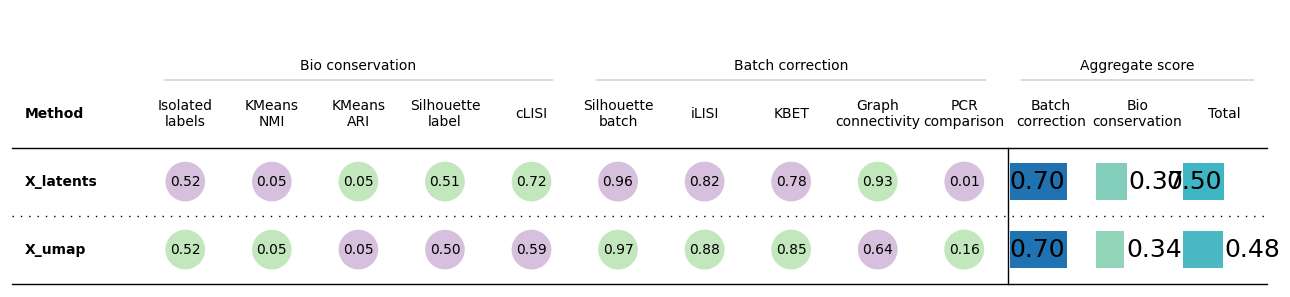

In [53]:
bm_latent_flat = Benchmarker(
    concat_flat[concat_flat.obs.experimental_time>0],
    batch_key="dataset_type",
    label_key="experimental_time",
    embedding_obsm_keys=["X_latents", "X_umap"],
    n_jobs=1,
)
bm_latent_flat.benchmark()
bm_latent_flat.plot_results_table(min_max_scale=False)

**Check scIB metrics data space**

In [ ]:
bm_vae = Benchmarker(
    concat_vae_x,
    batch_key="dataset_type",
    label_key="experimental_time",
    embedding_obsm_keys=["X_pca", "X_umap"],
    n_jobs=1,
)
bm_vae.plot_results_table(min_max_scale=False)

In [ ]:
bm_flat = Benchmarker(
    concat_flat_x,
    batch_key="dataset_type",
    label_key="experimental_time",
    embedding_obsm_keys=["X_pca", "X_umap"],
    n_jobs=2,
)
bm_flat.plot_results_table(min_max_scale=False)

In [ ]:
bm_flat.plot_results_table(min_max_scale=False)

**Check distribution distances**

In [57]:
from scCFM.models.cfm.components.optimal_transport import wasserstein

In [82]:
standardize_adata(concat_vae, "X_std")
standardize_adata(concat_flat, "X_std")

In [112]:
distribution_distances_vae = {}
distribution_distances_flat = {}

for i in range(1, len(idx2time)):
    condition_vae = np.logical_and(concat_vae.obs.dataset_type=="simulated", 
                                   concat_vae.obs.experimental_time==idx2time[i])
    condition_real_vae = np.logical_and(concat_vae.obs.dataset_type=="real", 
                                   concat_vae.obs.experimental_time==idx2time[i])
    
    X_latents_vae = torch.from_numpy(concat_vae[condition_vae].layers["X_std"])
    X_latents_real_vae = torch.from_numpy(concat_vae[condition_real_vae].layers["X_std"])
    m_vae = compute_distribution_distances(X_latents_vae.unsqueeze(1), 
                                            X_latents_real_vae.unsqueeze(1))
    distribution_distances_vae = add_keys_to_dict(distribution_distances_vae, m_vae)
    
    
    condition_flat = np.logical_and(concat_flat.obs.dataset_type=="simulated", 
                                   concat_flat.obs.experimental_time==idx2time[i])
    condition_real_flat = np.logical_and(concat_flat.obs.dataset_type=="real", 
                                   concat_flat.obs.experimental_time==idx2time[i])
    
    X_latents_flat = torch.from_numpy(concat_flat[condition_flat].layers["X_std"])
    X_latents_real_flat = torch.from_numpy(concat_flat[condition_real_flat].layers["X_std"])
    m_flat = compute_distribution_distances(X_latents_flat.unsqueeze(1), 
                                             X_latents_real_flat.unsqueeze(1))
    distribution_distances_flat = add_keys_to_dict(distribution_distances_flat, m_flat)

In [114]:
pd.DataFrame(distribution_distances_vae)

1-Wasserstein  2-Wasserstein  Linear_MMD  Poly_MMD   RBF_MMD  Mean_MSE  \
0       1.311192       1.382993    0.013302  0.115333  0.093526  0.017442   
1       1.514475       1.624068    0.024393  0.156183  0.134628  0.018902   
2       1.552191       1.687424    0.026620  0.163156  0.141464  0.020766   
3       1.768344       1.982043    0.049221  0.221857  0.196633  0.040610   

    Mean_L2   Mean_L1  
0  0.132068  0.105548  
1  0.137484  0.111132  
2  0.144102  0.123886  
3  0.201518  0.175038

In [116]:
pd.DataFrame(distribution_distances_flat)

1-Wasserstein  2-Wasserstein  Linear_MMD  Poly_MMD   RBF_MMD  Mean_MSE  \
0       1.295864       1.351698    0.003528  0.059400  0.051322  0.003294   
1       1.430269       1.502826    0.007325  0.085588  0.075418  0.009069   
2       1.526886       1.615207    0.014208  0.119198  0.108072  0.008140   
3       1.667547       1.816143    0.022466  0.149888  0.136243  0.016244   

    Mean_L2   Mean_L1  
0  0.057391  0.047198  
1  0.095231  0.078259  
2  0.090220  0.085645  
3  0.127451  0.111887